In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter
from sklearn import preprocessing
from tqdm import tqdm
import random
import tensorflow as tf

In [2]:
os.listdir("./data")

['004#biGRU_diff.csv',
 'dlstm_diff.zip',
 'decode_train_neg.csv',
 'test2_match.csv',
 'test_match.csv',
 'decode_train_neg_spe.csv',
 'sqli_trian.zip',
 'train_match.csv',
 'sqli_submit_9878.json',
 'sqli_test_1',
 'test.csv',
 'train.csv',
 'test_neg_spe.csv',
 'sqli_test_2',
 'test_pos.csv',
 'sqli_train',
 'test_neg_pos.csv',
 'dlstm_diff.csv',
 'decode_train_neg_pos.csv',
 'decode_train_pos.csv',
 '004#dlstm_diff.csv',
 'test2.csv',
 'sqli_test_2.zip',
 'test_neg.csv',
 'sqli_test_1-.zip',
 '007#bi-GRU-MaxPool.csv']

In [12]:
tf.reset_default_graph()

# Parameters
learning_rate = 0.01
training_steps = 500
batch_size = 100
display_step = 50

# Network Parameters
seq_max_len = 300 # Sequence max length
vocab_len = 69
n_hidden = 1 # hidden layer num of features
n_classes = 2 # linear sequence or not

# tf Graph input
x = tf.placeholder("float", [None, seq_max_len, vocab_len])
y = tf.placeholder("float", [None, n_classes])
# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int32, [None,])

# # Define weights
# weights = {
#     'out': tf.Variable(tf.random_normal([100, n_classes], seed=2018))
# }
# biases = {
#     'out': tf.Variable(tf.random_normal([n_classes], seed=2018))
# }



# Get lstm cell output, providing 'sequence_length' will perform dynamic calculation.
with tf.variable_scope("LSTM") as scope:
    # Define a lstm cell with tensorflow
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, state_is_tuple=True)
    print("lstm_cell", lstm_cell)
#     init_state = lstm_cell.zero_state(batch_size, dtype=tf.float32)
#     print("init_state", lstm_cell)
    outputs, states = tf.nn.dynamic_rnn(lstm_cell, x, dtype=tf.float32)
    print("outputs", outputs)
#     print("states", states)
    
with tf.variable_scope("softmax"):
    softmax_w = tf.get_variable("softmax_w",
                                shape=[n_hidden, n_classes],
                                initializer=tf.truncated_normal_initializer(stddev=0.05, seed=2018),
                                dtype=tf.float32)
    softmax_b = tf.get_variable("softmax_b",
                                shape=[n_classes],
                                initializer=tf.constant_initializer(value=0.),
                                dtype=tf.float32)
    reshape = tf.reshape(outputs, [-1, n_hidden])
    xw_plus_b = tf.nn.xw_plus_b(reshape, softmax_w, softmax_b)
    print("xw_plus_b:", xw_plus_b)
    logits = tf.reshape(xw_plus_b, [-1, seq_max_len, n_classes])
    print("logits:", logits)
    logits_softmax = tf.nn.softmax(logits)
    print("logits_softmax:", logits_softmax)
    
with tf.variable_scope("output"):
    # Hack to build the indexing and retrieve the right output.
    batch_size_ = tf.shape(outputs)[0]
    # Start indices for each sample
    index = tf.range(0, batch_size_) * seq_max_len + (seqlen - 1)
    # Indexing
    pred = tf.gather(tf.reshape(logits, [-1, n_classes]), index)
    print("pred", pred)


with tf.name_scope("loss"):
#     print(outputs)
    # Linear activation, using outputs computed above
#     pred = tf.matmul(weights['out'], outputs) + biases['out']

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    

with tf.name_scope("train"):
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
with tf.name_scope("valid"):
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

lstm_cell <tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell object at 0x7f651ce21080>
outputs Tensor("LSTM/rnn/transpose:0", shape=(?, 300, 1), dtype=float32)
xw_plus_b: Tensor("softmax/xw_plus_b:0", shape=(?, 2), dtype=float32)
logits: Tensor("softmax/Reshape_1:0", shape=(?, 300, 2), dtype=float32)
logits_softmax: Tensor("softmax/Reshape_3:0", shape=(?, 300, 2), dtype=float32)
pred Tensor("output/Gather:0", shape=(?, 2), dtype=float32)


/home/renxinzhang/.conda/envs/tf-gpu-1.3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [4]:
vocab = [v for v in ' !"#$%&\'()*+,-./0123456789:;<=>?@[\\]^_`abcdefghijklmnopqrstuvwxyz{|}~']
print("lable encoder vocab")
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(vocab)
print(label_encoder.classes_)

lable encoder vocab
[' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1'
 '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '<' '=' '>' '?' '@' '[' '\\' ']'
 '^' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o'
 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '{' '|' '}' '~']


In [5]:
def get_train_neg():
    train_pd = pd.read_csv("./data/test_neg.csv")
    train_pd = train_pd.dropna()
    max_seq = 300

    print("get word_list & label encoder")
    word_list = []
    for line in tqdm(train_pd.value):
        word_list.append([w for w in line][:max_seq])
    word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
    del word_list

    print("padding & one-hot x data")
    x_batch_pad = []
    for x in tqdm(word_labelencoder[:]):
        list_test = [0] * max_seq
        list_test[:len(x)] = x
        x_batch_pad.append(list_test)
    x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
    x_batch_size = [len(i) for i in word_labelencoder]
    del word_labelencoder

    print("padding & one-hot y data")
    y_batch = [0] * len(x_batch_pad)
    y_batch_pad = [np.eye(2)[item] for item in y_batch]
    y_batch_pad = [list(i) for i in y_batch_pad]
    return x_batch_pad, x_batch_size, y_batch_pad

In [6]:
def get_train_neg_pos():
    train_pd = pd.read_csv("./data/test_neg_pos.csv")
    train_pd = train_pd.dropna()
    max_seq = 300

    print("get word_list & label encoder")
    word_list = []
    for line in tqdm(train_pd.value):
        word_list.append([w for w in line][:max_seq])
    word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
    del word_list

    print("padding & one-hot x data")
    x_batch_pad = []
    for x in tqdm(word_labelencoder[:]):
        list_test = [0] * max_seq
        list_test[:len(x)] = x
        x_batch_pad.append(list_test)
    x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
    x_batch_size = [len(i) for i in word_labelencoder]
    del word_labelencoder

    print("padding & one-hot y data")
    y_batch = [0] * len(x_batch_pad)
    y_batch_pad = [np.eye(2)[item] for item in y_batch]
    y_batch_pad = [list(i) for i in y_batch_pad]
    return x_batch_pad, x_batch_size, y_batch_pad

In [7]:
def get_train_neg_sep():
    train_pd = pd.read_csv("./data/test_neg_spe.csv")
    train_pd = train_pd.dropna()
    max_seq = 300

    print("get word_list & label encoder")
    word_list = []
    for line in tqdm(train_pd.value):
        word_list.append([w for w in line][:max_seq])
    word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
    del word_list

    print("padding & one-hot x data")
    x_batch_pad = []
    for x in tqdm(word_labelencoder[:]):
        list_test = [0] * max_seq
        list_test[:len(x)] = x
        x_batch_pad.append(list_test)
    x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
    x_batch_size = [len(i) for i in word_labelencoder]
    del word_labelencoder

    print("padding & one-hot y data")
    y_batch = [0] * len(x_batch_pad)
    y_batch_pad = [np.eye(2)[item] for item in y_batch]
    y_batch_pad = [list(i) for i in y_batch_pad]
    return x_batch_pad, x_batch_size, y_batch_pad

In [8]:
def get_train_pos():
    train_pd = pd.read_csv("./data/test_pos.csv")
    max_seq = 300

    print("get word_list & label encoder")
    word_list = []
    for line in tqdm(train_pd.value):
        word_list.append([w for w in line][:max_seq])
    word_labelencoder = [list(label_encoder.transform(w)) for w in word_list]
    del word_list

    print("padding & one-hot x data")
    x_batch_pad = []
    for x in tqdm(word_labelencoder[:]):
        list_test = [0] * max_seq
        list_test[:len(x)] = x
        x_batch_pad.append(list_test)
    x_batch_pad = [np.eye(len(vocab))[item] for item in x_batch_pad]
    x_batch_size = [len(i) for i in word_labelencoder]
    del word_labelencoder

    print("padding & one-hot y data")
    y_batch = [1] * len(x_batch_pad)
    y_batch_pad = [np.eye(2)[item] for item in y_batch]
    y_batch_pad = [list(i) for i in y_batch_pad]
#     return x_batch_pad[6000:], x_batch_size[6000:], y_batch_pad[6000:]
#     return x_batch_pad[:9969+1], x_batch_size[:9969+1], y_batch_pad[:9969+1]
    return x_batch_pad[11:], x_batch_size[11:], y_batch_pad[11:]

In [38]:
# test_data, test_seqlen, test_label = get_train_pos()
test_data, test_seqlen, test_label = get_train_neg()
# test_data, test_seqlen, test_label = get_train_neg_pos()
# test_data, test_seqlen, test_label = get_train_neg_sep()
test_data, test_seqlen, test_label = np.array(test_data), np.array(test_seqlen), np.array(test_label)
print(test_data.shape, test_seqlen.shape, test_label.shape)

 27%|██▋       | 75261/275214 [00:00<00:00, 485862.84it/s]

get word_list & label encoder


  2%|▏         | 4873/275214 [00:00<00:08, 32593.00it/s]

padding & one-hot x data


100%|██████████| 275214/275214 [00:01<00:00, 190254.54it/s]


padding & one-hot y data
(275214, 300, 69) (275214,) (275214, 2)


In [39]:
tmp = np.argmax(test_data[0], axis=1)
tmp = [label_encoder.inverse_transform(item) for item in tmp]
# tmp = ["".join(list(item)).strip() for item in tmp]
"".join(list(tmp)).strip()

'user denied your request.'

In [40]:
'-2758"))) union all select 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432--  and ((("qwlp"="qwlp'

'-2758"))) union all select 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432, 4432--  and ((("qwlp"="qwlp'

In [41]:
len(test_data)//5000

55

In [42]:
LOG_DIR = "./logs/012_BasicModel++/"
saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
module_file = tf.train.latest_checkpoint(LOG_DIR)

test_pred = ''
# Start training
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  
with tf.Session(config=config) as sess:
    
    saver.restore(sess, module_file)

    for i in range((len(test_data)//5000)+1):
#         print(i*5000,(i+1)*5000)
        feed_dict_tmp={}
        feed_dict_tmp[x] = test_data[i*5000:(i+1)*5000]
        feed_dict_tmp[y] = test_label[i*5000:(i+1)*5000]
        feed_dict_tmp[seqlen] = test_seqlen[i*5000:(i+1)*5000]
        if i == 0:
            test_pred, test_acc, test_output = sess.run([pred, accuracy, logits_softmax], feed_dict=feed_dict_tmp)
#             print(len(feed_dict_tmp[x]))
            print("\t",i*5000,(i+1)*5000,"Testing Accuracy:", test_acc)
            test_acc = test_acc * len(feed_dict_tmp[x]) / len(test_data) 
        else:
            test_pred_tmp, test_acc_tmp, test_output_tmp = sess.run([pred, accuracy, logits_softmax], feed_dict=feed_dict_tmp)
            test_pred = np.vstack((test_pred, test_pred_tmp))
            test_output = np.vstack((test_output, test_output_tmp))
            test_acc += test_acc_tmp * len(feed_dict_tmp[x]) / len(test_data) 
#             print(len(feed_dict_tmp[x]))
            print("\t",i*5000,(i+1)*5000,"Testing Accuracy:", test_acc_tmp)
            
    # Calculate accuracy
#     test_data = sqli_batch.test_x
#     test_label = sqli_batch.test_y
#     test_seqlen = sqli_batch.test_size
#     test_pred, test_acc, test_output = sess.run([pred, accuracy, logits_softmax], feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})
#     print("Testing Accuracy:", test_acc)
    print("Testing Accuracy:", test_acc)

INFO:tensorflow:Restoring parameters from ./logs/012_BasicModel++/sqli.ckpt-500
	 0 5000 Testing Accuracy: 1.0
	 5000 10000 Testing Accuracy: 0.9992
	 10000 15000 Testing Accuracy: 0.9998
	 15000 20000 Testing Accuracy: 1.0
	 20000 25000 Testing Accuracy: 1.0
	 25000 30000 Testing Accuracy: 0.9994
	 30000 35000 Testing Accuracy: 0.9994
	 35000 40000 Testing Accuracy: 0.9998
	 40000 45000 Testing Accuracy: 0.9998
	 45000 50000 Testing Accuracy: 0.9998
	 50000 55000 Testing Accuracy: 0.9994
	 55000 60000 Testing Accuracy: 0.9992
	 60000 65000 Testing Accuracy: 0.9988
	 65000 70000 Testing Accuracy: 0.9998
	 70000 75000 Testing Accuracy: 1.0
	 75000 80000 Testing Accuracy: 0.9996
	 80000 85000 Testing Accuracy: 1.0
	 85000 90000 Testing Accuracy: 1.0
	 90000 95000 Testing Accuracy: 0.9998
	 95000 100000 Testing Accuracy: 0.9998
	 100000 105000 Testing Accuracy: 0.9996
	 105000 110000 Testing Accuracy: 0.9988
	 110000 115000 Testing Accuracy: 0.9996
	 115000 120000 Testing Accuracy: 0.9996

In [43]:
# LOG_DIR = "./logs/012_BasicModel++/"
# saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)
# module_file = tf.train.latest_checkpoint(LOG_DIR)

# test_pred = ''
# # Start training
# config = tf.ConfigProto()  
# config.gpu_options.allow_growth = True  
# with tf.Session(config=config) as sess:
    
#     saver.restore(sess, module_file)

            
#     # Calculate accuracy
# #     test_data = sqli_batch.test_x
# #     test_label = sqli_batch.test_y
# #     test_seqlen = sqli_batch.test_size
#     test_pred, test_acc, test_output = sess.run([pred, accuracy, logits_softmax], feed_dict={x: test_data, y: test_label, seqlen: test_seqlen})
#     print("Testing Accuracy:", test_acc)

In [44]:
test_pred.shape

(275214, 2)

In [45]:
from sklearn.utils.extmath import softmax

test_pred_label = np.argmax(test_pred, 1)
test_real_label = np.argmax(test_label, 1)
test_diff = test_pred_label != test_real_label
test_diff_index = np.where(test_diff == True)[0]
print("diff len:", len(test_diff_index))

# test_data = sqli_batch.test_x
# test_label = sqli_batch.test_y
# test_seqlen = sqli_batch.test_size

diff_x = test_data[test_diff_index]
diff_x = np.argmax(diff_x, 2)

diff_y = test_label[test_diff_index]
diff_y = np.argmax(diff_y, 1)

test_pred_softmax = softmax(test_pred)
# test_pred_softmax = test_pred
pred_y = test_pred_softmax[test_diff_index]
pred_y = [item[1] for item in pred_y]
pred_class = test_pred_label[test_diff_index]

diff_x = [label_encoder.inverse_transform(item) for item in diff_x]
diff_value = ["".join(list(item)).strip() for item in diff_x]

diff_pd = pd.DataFrame(diff_value, columns=['value'])
diff_pd['label'] = diff_y
diff_pd['pred'] = pred_y
diff_pd['plabel'] = pred_class
diff_pd['id'] = test_diff_index
diff_pd.to_csv("./result/12#neg.csv", index=False)
diff_pd

diff len: 119


,value,label,pred,plabel,id
0,"18,218976,106557;18,218977,106557",0,0.701949,1,5313
1,"13,6688,3160;13,6687,3160;13,6689,3160;13,6688...",0,0.991292,1,6539
2,synxxzj1q,0,0.534976,1,8596
3,,0,0.654371,1,9545
4,"16,53786,25037;16,53787,25037;16,53786,25036;1...",0,0.980596,1,11119
5,__,0,0.835425,1,28280
6,", . . 10 .",0,0.991338,1,29000
7,~,0,0.764041,1,29132
8,lxn3qtndnwu9,0,0.554897,1,30175
9,,0,0.919709,1,30258


In [29]:
show_index = 9950
showitem = test_data[show_index]
showitem_len = test_seqlen[show_index]
print(showitem.shape)
showitem = np.argmax(showitem, 1)
print(showitem.shape)
heatmap_x = [label_encoder.inverse_transform(item) for item in showitem]
heatmap_x = heatmap_x[:showitem_len]
print(showitem_len)
heatmap_y = test_output[show_index][:showitem_len]
heatmap_y = [[row[1] for row in heatmap_y]]

(300, 69)
(300,)
263


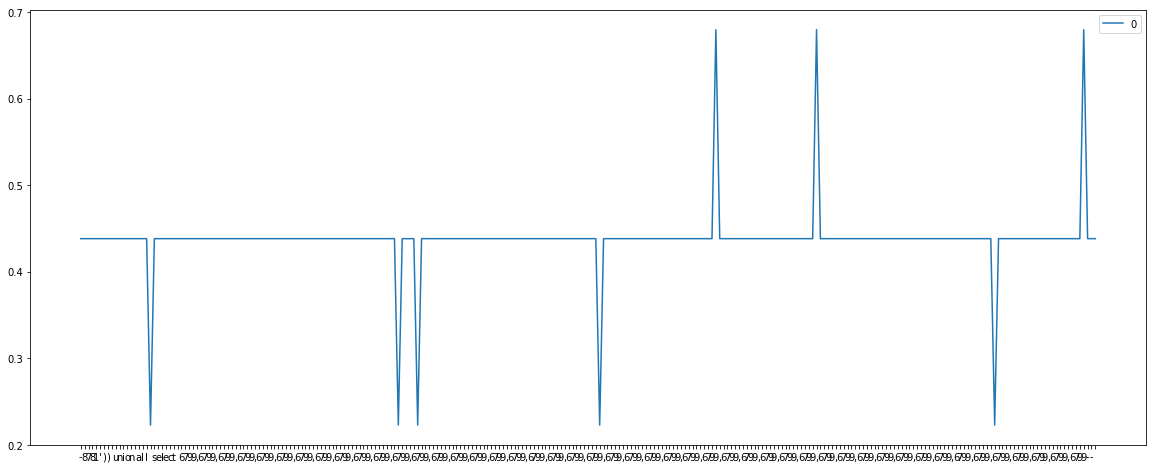

In [30]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(20, 8)) # set figure size
for i in range(1):
    plt.plot(heatmap_y[i][:len(heatmap_x)], label=str(i))
xticks = range(0,len(heatmap_x))
ax.set_xticks(xticks) # major ticks
ax.set_xticklabels(heatmap_x)   # labels should be 'unicode'
plt.legend(loc='upper right')
plt.show()